# Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# ML algorithms & metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# saving model
import joblib

In [234]:
%matplotlib inline


# Helper Functions

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



def regression_metrics_df(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name):
    """
    Calculate regression metrics and create a DataFrame with metrics for training and test sets.

    Parameters:
    - y_train_true: True values for the training set.
    - y_train_pred: Predicted values for the training set.
    - y_test_true: True values for the test set.
    - y_test_pred: Predicted values for the test set.
    - model_name: Name of the model as a string.

    Returns:
    - DataFrame with regression metrics.
    """
    # Calculate metrics for training set
    train_rmse = round(np.sqrt(mean_squared_error(y_train_true, y_train_pred)), 2)
    train_mae = round(mean_absolute_error(y_train_true, y_train_pred), 2)
    train_r2 = round(r2_score(y_train_true, y_train_pred), 2)
    train_mape = round(np.mean(np.abs((y_train_true - y_train_pred) / y_train_true)) * 100, 1)
    train_relative_error = round((train_rmse / y_train_true.mean()) * 100, 1)

    # Calculate metrics for test set
    test_rmse = round(np.sqrt(mean_squared_error(y_test_true, y_test_pred)), 2)
    test_mae = round(mean_absolute_error(y_test_true, y_test_pred), 2)
    test_r2 = round(r2_score(y_test_true, y_test_pred), 2)
    test_mape = round(np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100, 1)
    test_relative_error = round((test_rmse / y_test_true.mean()) * 100, 1)

    # Create the metrics DataFrame
    metrics_dict = {
        'Metric': ['RMSE', 'MAPE (%)', 'R2 Score', 'MAE', 'Relative Error to Mean (%)'],
        'Train Set': [
            train_rmse,
            train_mape,
            train_r2,
            train_mae,
            train_relative_error
        ],
        'Test Set': [
            test_rmse,
            test_mape,
            test_r2,
            test_mae,
            test_relative_error
        ],
        'Model': [model_name] * 5
    }

    df = pd.DataFrame(metrics_dict)
    return df


def calculate_cv_metrics_regression(model, X, y, model_name, cv=5):
    """
    Calculate cross-validation metrics for a regression model.

    Parameters:
    - model: The regressor model.
    - X: Feature matrix.
    - y: Target vector.
    - cv: Number of cross-validation folds. Default is 5.
    - model_name: Name of the model.

    Returns:
    - metrics_df: DataFrame with mean and standard deviation of the cross-validation scores for multiple metrics.
    """
    # Define scoring metrics in the desired order
    metrics = {
        'RMSE': make_scorer(mean_squared_error, squared=False),  # squared=False gives RMSE
        'MAPE (%)': make_scorer(lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100),
        'R2 Score': make_scorer(r2_score),
        'MAE': make_scorer(mean_absolute_error)
    }

    # Initialize results dictionary
    results = {'Metric': [], 'CV Mean': [], 'CV Std': [], 'Model': []}

    # Calculate scores for each metric
    for metric_name, scorer in metrics.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        results['Metric'].append(metric_name)
        results['CV Mean'].append(f'{mean_score:.2f}')
        results['CV Std'].append(f'{std_score:.2f}')
        results['Model'].append(model_name)

    # Create DataFrame from results
    metrics_df = pd.DataFrame(results)

    return metrics_df


def combine_and_format_metrics(dfs):
    """
    Combine multiple DataFrames with classification metrics and format them into a single DataFrame.

    Parameters:
    - dfs: List of DataFrames with metrics.

    Returns:
    - DataFrame with combined and formatted metrics.
    """
    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)

    # Pivot the DataFrame
    metrics_pivot = combined_df.pivot(index='Model', columns='Metric', values=['Train Set', 'Test Set'])

    # Flatten the multi-level columns
    metrics_pivot.columns = [f'{col[1]} {col[0]}' for col in metrics_pivot.columns]

    # Reset index to get 'Model' as a column
    metrics_pivot.reset_index(inplace=True)

    return metrics_pivot


############################################# Plotting

def plot_feature_importance(coef, feature_names, model_name):
    """
    Plots the feature importance based on the coefficients of a model.

    Parameters:
    - coef: Array-like, shape (n_features,)
      Coefficients of the features from the model.
    - feature_names: List of strings
      Names of the features.
    - model_name: String
      Name of the model.
    """
    # Create a Series with the feature names as the index
    feature_importance = pd.Series(coef, index=feature_names)

    # Sort the values in descending order
    feature_importance = feature_importance.sort_values(ascending=False)

    # Plot the feature importance using seaborn
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importance.values, y=feature_importance.index, hue=feature_importance.index, palette="Blues_r")
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')
    plt.show()

def plot_residuals(y_true, y_pred, title):
    """
    Plots the residuals of a regression model's predictions.

    Parameters:
    - y_true: Actual target values.
    - y_pred: Predicted target values by the model.
    - title: Title of the plot.

    Returns:
    - None (displays the residuals plot).
    """
    # Calculate residuals
    residuals = y_true - y_pred

    # Calculate mean and standard deviation of residuals
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    # Create the residuals plot
    fig = px.scatter(
        x=y_pred,
        y=residuals,
        labels={'x': 'Predicted Values', 'y': 'Residuals'},
        title=title
    )

    # Add a horizontal line at y=0 for reference
    fig.add_hline(y=0, line_dash="dash", line_color="red", annotation_text="Zero Error", annotation_position="bottom right")

    # Add a horizontal line for the mean residual
    fig.add_hline(y=mean_residual, line_dash="dot", line_color="blue", annotation_text=f"Mean Residual: {mean_residual:.2f}", annotation_position="bottom left")

    # Add shaded region for one standard deviation around the mean residual
    fig.add_shape(
        type="rect",
        x0=min(y_pred), x1=max(y_pred), y0=mean_residual - std_residual, y1=mean_residual + std_residual,
        fillcolor="lightblue", opacity=0.3, line_width=0
    )
    fig.add_annotation(
        text=f"1 Std Dev ({std_residual:.2f})",
        xref="paper", yref="y",
        x=0.95, y=mean_residual + std_residual,
        showarrow=False, font=dict(color="blue")
    )

    # Improve layout and display the plot
    fig.update_layout(
        xaxis_title="Predicted Values",
        yaxis_title="Residuals",
        template="plotly_white",
        hovermode="closest"
    )
    fig.show()

def plot_regression_metrics(metrics_df):
    """
    Plots model performance metrics using subplots arranged in the same row for each metric.
    Different colors and shapes are used for Train Set and Test Set, with a single legend.

    Parameters:
    - metrics_df: DataFrame containing the metrics to plot, including Metric, Train Set, and Test Set columns.

    Returns:
    - None (displays the plots).
    """
    # Melt the DataFrame to long format for easier plotting with Plotly
    metrics_long_df = metrics_df.melt(id_vars=['Metric', 'Model'], value_vars=['Train Set', 'Test Set'],
                                      var_name='Set', value_name='Value')

    # Number of unique metrics
    metrics = metrics_df['Metric'].unique()
    num_metrics = len(metrics)

    # Create subplots
    fig = make_subplots(rows=1, cols=num_metrics, subplot_titles=metrics,
                        horizontal_spacing=0.1)

    # Define color and shape for Train Set and Test Set
    colors = {'Train Set': 'blue', 'Test Set': 'orange'}
    symbols = {'Train Set': 'circle', 'Test Set': 'square'}

    # Add scatter plots for each metric
    for i, metric in enumerate(metrics):
        # Filter data for the current metric
        metric_df = metrics_long_df[metrics_long_df['Metric'] == metric]

        for set_type in ['Train Set', 'Test Set']:
            # Filter data for the current set_type
            set_df = metric_df[metric_df['Set'] == set_type]

            # Create scatter plot for the current set_type
            scatter = go.Scatter(
                x=set_df['Model'],
                y=set_df['Value'],
                mode='markers+text',
                marker=dict(size=10, color=colors[set_type], symbol=symbols[set_type], opacity=0.8),
                text=set_df['Value'],
                textposition='top center',
                name=set_type,
                showlegend=True if i == 0 else False  # Show legend only in the first subplot
            )

            # Add scatter plot to the subplot
            fig.add_trace(scatter, row=1, col=i+1)

    # Update layout for better visualization
    fig.update_layout(
        title='Model Performance Metrics Comparison',
        xaxis_title="Model",
        yaxis_title="Metric Value",
        template="plotly_white",
        height=400,  # Adjust height as needed
        width=200 + (num_metrics - 1) * 200,  # Adjust width based on number of metrics
        margin=dict(l=50, r=50, t=50, b=50),
        legend=dict(
            title='Set',
            x=1,  # Position legend on the right
            y=0.5,
            traceorder='normal',
            orientation='v'
        )
    )

    # Display the plot
    fig.show()

def evaluate_and_plot_model_regression(model, X_train, y_train, X_test, y_test, model_name, cv_folds=5, include_cv=False):
    """
    Evaluate a regression model by predicting, plotting residuals,
    calculating regression metrics, and visualizing the metrics with Plotly.
    Optionally includes cross-validation metrics.

    Parameters:
    - model: Trained regression model.
    - X_train: Features of the training set.
    - y_train: Target values of the training set.
    - X_test: Features of the test set.
    - y_test: Target values of the test set.
    - model_name: Name of the model for labeling.
    - cv_folds: Number of cross-validation folds (default is 5).
    - include_cv: Boolean flag to include cross-validation metrics (default is False).

    Returns:
    - metrics_df: DataFrame containing the regression metrics for the model.
    - cv_metrics_df: DataFrame containing the cross-validation metrics for the model (if `include_cv` is True).
    """
    # Predict on training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate regression metrics
    metrics_df = regression_metrics_df(y_train, y_train_pred, y_test, y_test_pred, model_name)
    print(f"Regression Metrics for {model_name}:\n")
    display(metrics_df)
    print('\n')

    # Optionally calculate and display cross-validation metrics
    if include_cv:
        cv_metrics_df = calculate_cv_metrics_regression(model, X_train, y_train, model_name, cv=cv_folds)
        print(f"Cross-Validation Metrics for {model_name}:\n")
        display(cv_metrics_df)

        # Plot metrics
        plot_regression_metrics(metrics_df)

        # Plot residuals for train and test sets
        plot_residuals(y_train, y_train_pred, f'{model_name} Train Residuals')
        plot_residuals(y_test, y_test_pred, f'{model_name} Test Residuals')


        return metrics_df, cv_metrics_df

    # Plot residuals for train and test sets
    plot_residuals(y_train, y_train_pred, f'{model_name} Train Residuals')

    # Plot metrics with Plotly
    plot_regression_metrics(metrics_df)

    return metrics_df

from sklearn.model_selection import learning_curve

def plot_learning_curves_reg(model, X_train, y_train, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], model_name='Model'):
    """
    Plot learning curves for a given regression model and training data.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train: Features of the training set.
    - y_train: Labels of the training set.
    - train_sizes: List of training sizes to evaluate.
    - model_name: Name of the model for the plot title.

    Returns:
    - None
    """
    # Compute learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        n_jobs=-1,
        train_sizes=train_sizes
    )

    # Calculate mean and standard deviation of training and test scores
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.title(f"Learning Curves for {model_name}", fontsize=16)
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.grid(True)

    # Plot training and validation scores
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")

    # Fill areas between the mean score and standard deviation
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Annotate scores on the plot
    for i, size in enumerate(train_sizes):
        plt.text(size, train_scores_mean[i], f'{train_scores_mean[i]:.2f}', color='r', ha='center', va='bottom')
        plt.text(size, test_scores_mean[i], f'{test_scores_mean[i]:.2f}', color='g', ha='center', va='bottom')

    plt.legend(loc='best', shadow=True, fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_regression_models_metrics(data, width=1600, height=600):
    """
    Plots the comparison of regression metrics for different models using Plotly.
    Metrics with similar scales are plotted together in one subplot, while those with different scales are plotted in another.
    Both subplots are arranged in the same row.

    Parameters:
    data (pd.DataFrame): A DataFrame containing the regression metrics for different models.
    width (int): The width of the figure.
    height (int): The height of the figure.
    """
    # Adjust MAPE values by dividing by 100
    if 'MAPE (%) Train Set' in data.columns and 'MAPE (%) Test Set' in data.columns:
        data['MAPE (%) Train Set'] = data['MAPE (%) Train Set'] / 100
        data['MAPE (%) Test Set'] = data['MAPE (%) Test Set'] / 100

    # Define a color map for metrics
    color_map = {
        'RMSE': 'blue',
        'MAE': 'green',
        'R2 Score': 'orange',
        'MAPE (%)': 'red'
    }

    # List of metrics for each subplot
    metrics_figure_1 = ['RMSE', 'MAE']
    metrics_figure_2 = ['R2 Score', 'MAPE (%)']

    # Create subplots with 2 columns (one for each set of metrics)
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=['RMSE and MAE Metrics Comparison', 'R2 Score and MAPE Metrics Comparison'],
                        column_widths=[0.5, 0.5])

    # Helper function to add traces to the subplot
    def add_traces(metrics, row, col):
        for metric in metrics:
            color = color_map[metric]
            train_metric = f'{metric} Train Set'
            test_metric = f'{metric} Test Set'

            # Add Train Set line
            fig.add_trace(go.Scatter(
                x=data['Model'],
                y=data[train_metric],
                mode='lines+markers+text',
                line=dict(color=color),
                marker=dict(size=8),
                text=data[train_metric].apply(lambda x: f'{x:.2f}'),
                textposition='top right',
                textfont=dict(size=10, color=color),
                name=f'{metric} (Train Set)'
            ), row=row, col=col)

            # Add Test Set line
            fig.add_trace(go.Scatter(
                x=data['Model'],
                y=data[test_metric],
                mode='lines+markers+text',
                line=dict(color=color, dash='dash'),
                marker=dict(size=8),
                text=data[test_metric].apply(lambda x: f'{x:.2f}'),
                textposition='bottom right',
                textfont=dict(size=10, color=color),
                name=f'{metric} (Test Set)'
            ), row=row, col=col)

    # Add traces to each subplot
    add_traces(metrics_figure_1, row=1, col=1)
    add_traces(metrics_figure_2, row=1, col=2)

    # Update layout for the entire figure
    fig.update_layout(
        title='Comparison of Regression Metrics Across Models',
        xaxis_title='Model',
        yaxis_title='Score',
        legend_title='Metric',
        xaxis=dict(tickangle=-45),  # Rotate x-axis labels for better readability
        width=width,
        height=height,
        showlegend=True
    )

    # Show the figure
    fig.show()




In [232]:
!wget https://raw.githubusercontent.com/ezzaddeentru/used-cars-selling-price-estimating---case-study/main/reg_helper_functions.py

--2024-08-14 01:09:34--  https://raw.githubusercontent.com/ezzaddeentru/used-cars-selling-price-estimating---case-study/main/reg_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17756 (17K) [text/plain]
Saving to: ‘reg_helper_functions.py’

reg_helper_function 100%[===================>]  17.34K  --.-KB/s    in 0s      

2024-08-14 01:09:34 (106 MB/s) - ‘reg_helper_functions.py’ saved [17756/17756]



In [233]:
from reg_helper_functions import regression_metrics_df, calculate_cv_metrics_regression
from reg_helper_functions import evaluate_and_plot_model_regression
from reg_helper_functions import plot_regression_metrics, plot_residuals, plot_learning_curves_reg, plot_feature_importance
from reg_helper_functions import combine_and_format_metrics, plot_regression_models_metrics


# Data

In [1]:
!wget https://raw.githubusercontent.com/ezzaddeentru/used-cars-selling-price-estimating---case-study/main/toyota.csv

--2024-08-13 22:12:39--  https://raw.githubusercontent.com/ezzaddeentru/used-cars-selling-price-estimating---case-study/main/toyota.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347863 (340K) [text/plain]
Saving to: ‘toyota.csv’

toyota.csv          100%[===================>] 339.71K  --.-KB/s    in 0.006s  

2024-08-13 22:12:40 (54.0 MB/s) - ‘toyota.csv’ saved [347863/347863]



In [4]:
data = pd.read_csv('toyota.csv')
df0 = data.copy()
df0 = df0[df0['transmission'] != 'Other']  # just one point for Other
df0 = df0[df0['year'] != 1998]  # price is an outlier for this year


train_set, test_set = train_test_split(df0, test_size=0.2, random_state=42)

# num pipeline
num_pipeline = make_pipeline(StandardScaler())

# cat pipeline
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

# full pipeline
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

train_set_features = train_set.drop('price', axis=1)
train_set_labels = train_set['price']

train_set_prepared = preprocessing.fit_transform(train_set_features)
train_set_prepared_df = pd.DataFrame(train_set_prepared, columns=preprocessing.get_feature_names_out())

X_train = train_set_prepared
y_train = train_set_labels

test_set_features = test_set.drop('price', axis=1)
test_set_labels = test_set['price']

test_set_prepared = preprocessing.transform(test_set_features)
test_set_prepared_df = pd.DataFrame(test_set_prepared, columns=preprocessing.get_feature_names_out())

X_test = test_set_prepared
y_test = test_set_labels

In [8]:
print(f'Data shape: {data.shape}')
print(f'df0 shape: {df0.shape}')
print(f'train_set shape: {train_set.shape}')
print(f'test_set shape: {test_set.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


Data shape: (6738, 9)
df0 shape: (6736, 9)
train_set shape: (5388, 9)
test_set shape: (1348, 9)
X_train shape: (5388, 30)
y_train shape: (5388,)
X_test shape: (1348, 30)
y_test shape: (1348,)


# SVR

## Base Model

In [11]:
from sklearn.svm import SVR

# SVR
svr_reg = SVR()  # defualt rbf kernal
%time svr_reg.fit(X_train, y_train)

CPU times: user 2.98 s, sys: 339 ms, total: 3.32 s
Wall time: 3.97 s


SVR()

In [ ]:
y_train_pred_svr = svr_reg.predict(X_train)
y_test_pred_svr = svr_reg.predict(X_test)


In [25]:
svr_metrics_df = regression_metrics_df(y_train, y_train_pred_svr, y_test, y_test_pred_svr, 'SVR')
svr_metrics_df

,Metric,Train Set,Test Set,Model
0,RMSE,6282.87,6424.19,SVR
1,MAPE (%),34.70,34.60,SVR
2,R2 Score,0.01,-0.00,SVR
3,MAE,4108.43,4177.15,SVR
4,Relative Error to Mean (%),50.30,50.70,SVR


# LinearSVR

## Base Model

In [27]:
from sklearn.svm import LinearSVR

In [29]:
# linear SVR
lsvr_reg = LinearSVR(random_state=42, dual='auto')
%time lsvr_reg.fit(X_train, y_train)

CPU times: user 8.52 ms, sys: 0 ns, total: 8.52 ms
Wall time: 12.8 ms


LinearSVR(dual='auto', random_state=42)

### regression_metrics_df

In [30]:
y_train_pred_lsvr = lsvr_reg.predict(X_train)
y_test_pred_lsvr = lsvr_reg.predict(X_test)

In [138]:
lsvr_metrics_df = regression_metrics_df(y_train, y_train_pred_lsvr, y_test, y_test_pred_lsvr, 'Linear SVR')
lsvr_metrics_df

,Metric,Train Set,Test Set,Model
0,RMSE,6865.12,6995.58,Linear SVR
1,MAPE (%),27.00,27.90,Linear SVR
2,R2 Score,-0.18,-0.19,Linear SVR
3,MAE,4385.83,4547.63,Linear SVR
4,Relative Error to Mean (%),55.00,55.20,Linear SVR


### plot_regression_metrics

In [139]:
plot_regression_metrics(lsvr_metrics_df)

### plot_feature_importance

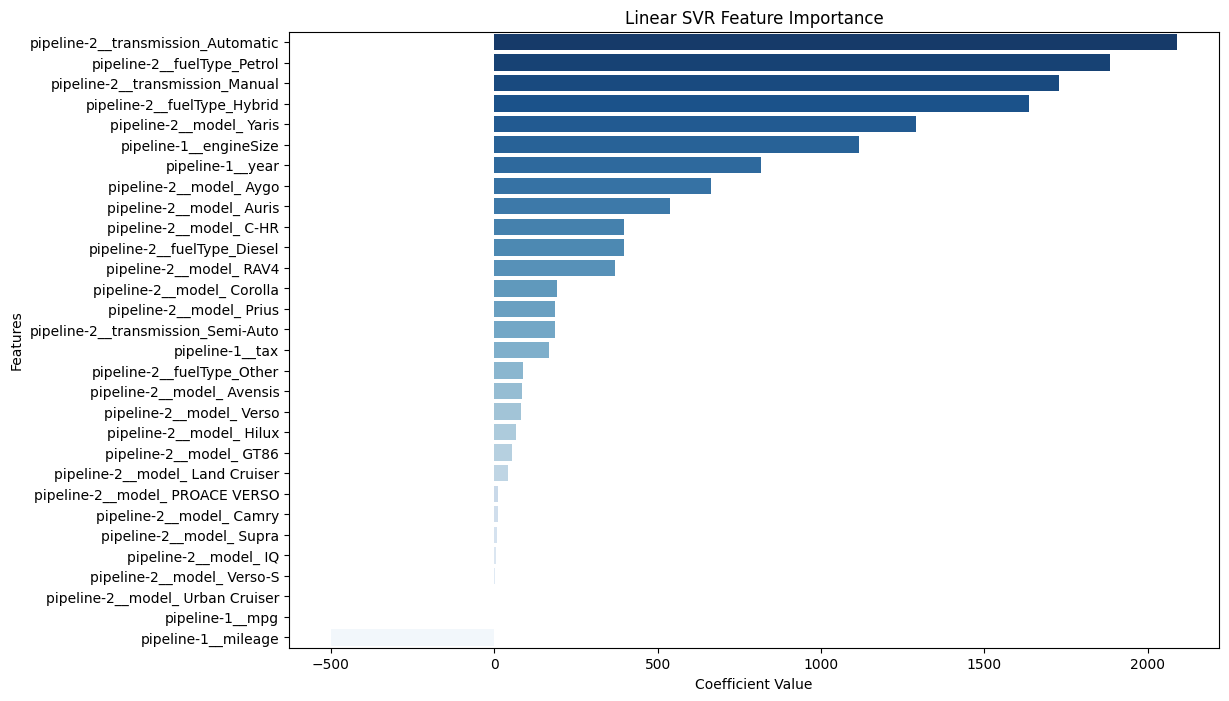

In [140]:
plot_feature_importance(lsvr_reg.coef_, preprocessing.get_feature_names_out(), 'Linear SVR')

### calculate_cv_metrics_regression

In [141]:
%time lsvr_rmse_scores = -cross_val_score(lsvr_reg, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)


CPU times: user 39.2 ms, sys: 27.9 ms, total: 67.1 ms
Wall time: 39.4 ms


In [143]:
lsvr_rmse_scores.mean()

7811.7836246436955

In [144]:
calculate_cv_metrics_regression(lsvr_reg, X_train, y_train, 'Linear SVR')

,Metric,CV Mean,CV Std,Model
0,RMSE,7811.78,227.16,Linear SVR
1,MAPE (%),32.92,0.28,Linear SVR
2,R2 Score,-0.53,0.04,Linear SVR
3,MAE,5230.06,65.89,Linear SVR


### plot_residuals

In [145]:
plot_residuals(y_train, y_train_pred_lsvr, 'Linear SVR Training Residuals')

In [146]:
plot_residuals(y_test, y_test_pred_lsvr, 'Linear SVR Test Residuals')

### evaluate_and_plot_model_regression

In [163]:
lsvr_metrics_df, lsvr_cv_metrics_df = evaluate_and_plot_model_regression(lsvr_reg,
                                                                         X_train, y_train, X_test, y_test,
                                                                         'Linear SVR',
                                                                         cv_folds=5,
                                                                         include_cv=True)

Regression Metrics for Linear SVR:



,Metric,Train Set,Test Set,Model
0,RMSE,6865.12,6995.58,Linear SVR
1,MAPE (%),27.00,27.90,Linear SVR
2,R2 Score,-0.18,-0.19,Linear SVR
3,MAE,4385.83,4547.63,Linear SVR
4,Relative Error to Mean (%),55.00,55.20,Linear SVR




Cross-Validation Metrics for Linear SVR:



,Metric,CV Mean,CV Std,Model
0,RMSE,7811.78,227.16,Linear SVR
1,MAPE (%),32.92,0.28,Linear SVR
2,R2 Score,-0.53,0.04,Linear SVR
3,MAE,5230.06,65.89,Linear SVR


In [170]:
import matplotlib.pyplot as plt



### plot_learning_curves_reg

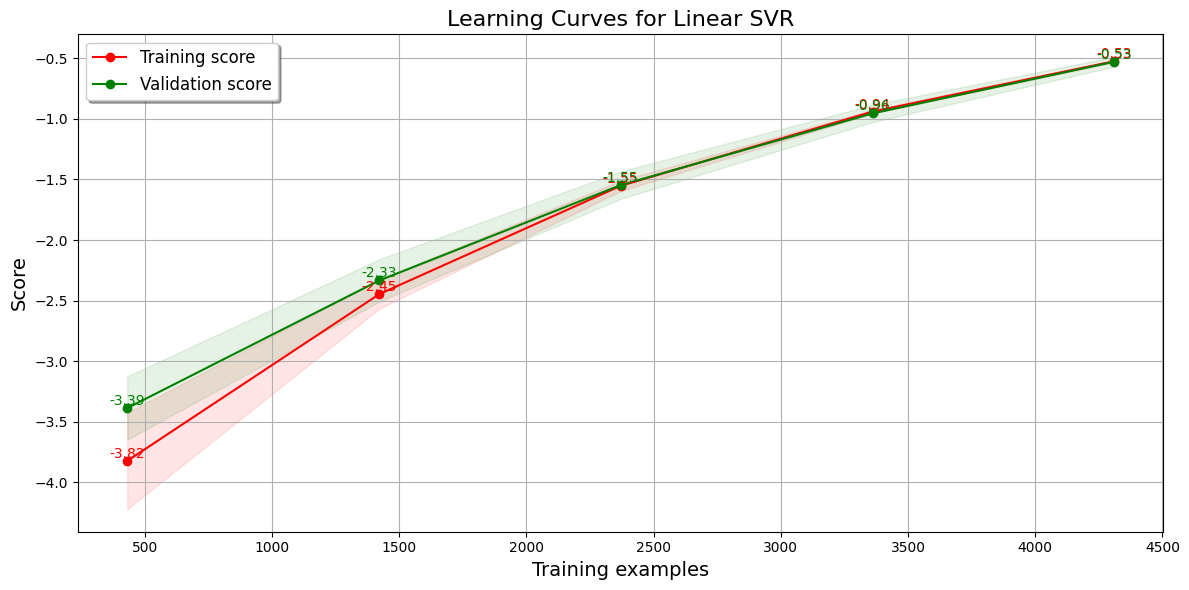

In [176]:
plot_learning_curves_reg(lsvr_reg, X_train, y_train, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], model_name='Linear SVR')


## Grid Search

In [180]:
# linear SVR
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1]
}

lsvr_gs_reg = GridSearchCV(lsvr_reg,
                           param_grid,
                           scoring='r2',
                           cv=5,
                           verbose=2)
%time lsvr_gs_reg.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................................C=0.1, epsilon=0.01; total time=   0.0s
[CV] END ................................C=0.1, epsilon=0.01; total time=   0.0s
[CV] END ................................C=0.1, epsilon=0.01; total time=   0.0s
[CV] END ................................C=0.1, epsilon=0.01; total time=   0.0s
[CV] END ................................C=0.1, epsilon=0.01; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END .................................C=0.1, epsilon=0.1; total time=   0.0s
[CV] END ...................................C=0.1, epsilon=1; total time=   0.0s
[CV] END ...................................C=0.

GridSearchCV(cv=5, estimator=LinearSVR(dual='auto', random_state=42),
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1]},
             scoring='r2', verbose=2)

In [184]:
print(f'LinearSVR base model parameters:')
lsvr_reg.get_params()

LinearSVR base model parameters:


{'C': 1.0,
 'dual': 'auto',
 'epsilon': 0.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [185]:
print(f'LinearSVR GridSearchCV best parameters:')
lsvr_gs_reg.best_params_

LinearSVR GridSearchCV best parameters:


{'C': 100, 'epsilon': 1}

In [186]:
lsvr_gs_reg.best_score_

0.8498972135858583

In [204]:
lsvr_gs_metrics_df, lsvr_gs_cv_metrics_df = evaluate_and_plot_model_regression(lsvr_gs_reg.best_estimator_,
                                                                                X_train, y_train, X_test, y_test,
                                                                                'GridSearch Linear SVR',
                                                                                cv_folds=5,
                                                                                include_cv=True)

Regression Metrics for GridSearch Linear SVR:



,Metric,Train Set,Test Set,Model
0,RMSE,2411.02,2501.07,GridSearch Linear SVR
1,MAPE (%),10.20,10.10,GridSearch Linear SVR
2,R2 Score,0.85,0.85,GridSearch Linear SVR
3,MAE,1181.00,1229.66,GridSearch Linear SVR
4,Relative Error to Mean (%),19.30,19.70,GridSearch Linear SVR




Cross-Validation Metrics for GridSearch Linear SVR:



,Metric,CV Mean,CV Std,Model
0,RMSE,2447.96,267.01,GridSearch Linear SVR
1,MAPE (%),10.36,0.57,GridSearch Linear SVR
2,R2 Score,0.85,0.02,GridSearch Linear SVR
3,MAE,1200.52,62.94,GridSearch Linear SVR


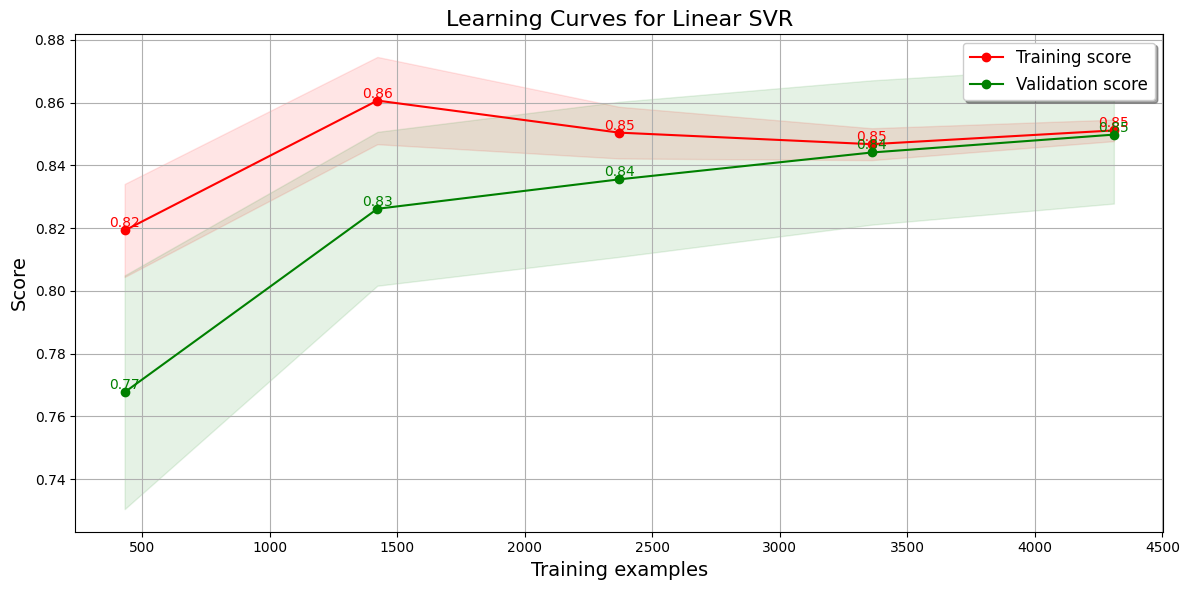

In [200]:
plot_learning_curves_reg(lsvr_gs_reg.best_estimator_, X_train, y_train, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], model_name='Linear SVR')

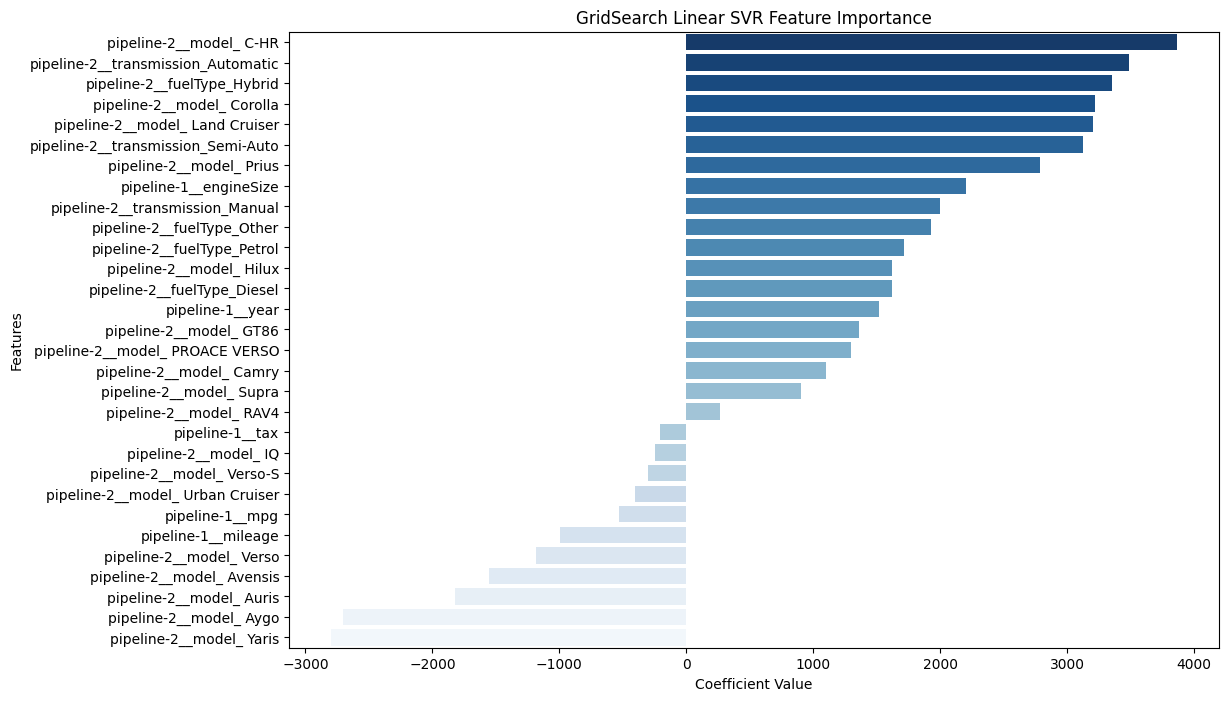

In [193]:
plot_feature_importance(lsvr_gs_reg.best_estimator_.coef_, preprocessing.get_feature_names_out(), 'GridSearch Linear SVR')

## combine_and_format_metrics

In [217]:
metrics_df_list = [svr_metrics_df, lsvr_metrics_df, lsvr_gs_metrics_df]
combined_metrics_df = combine_and_format_metrics(metrics_df_list)
combined_metrics_df

,Model,MAE Train Set,MAPE (%) Train Set,R2 Score Train Set,RMSE Train Set,Relative Error to Mean (%) Train Set,MAE Test Set,MAPE (%) Test Set,R2 Score Test Set,RMSE Test Set,Relative Error to Mean (%) Test Set
0,GridSearch Linear SVR,1181.00,10.2,0.85,2411.02,19.3,1229.66,10.1,0.85,2501.07,19.7
1,Linear SVR,4385.83,27.0,-0.18,6865.12,55.0,4547.63,27.9,-0.19,6995.58,55.2
2,SVR,4108.43,34.7,0.01,6282.87,50.3,4177.15,34.6,-0.00,6424.19,50.7


## plot_regression_models_metrics

In [231]:
plot_regression_models_metrics(combined_metrics_df)